# DeFi Research

In [88]:
import requests
import json
import pandas as pd
import seaborn as sns
import cryptocompare
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Importing Data

In [2]:
lastId='""'
data = []
#loop until no more data left
while(1):
    try:
        #set query
        query="""
        {
            borrows (first: 1000 orderBy: id where:{id_gt:"""+lastId+"""}) {
            id,
            amount,
            reserve {
              id,
              symbol
            },
            borrowRate,
            borrowRateMode,
            timestamp
            }
        }
        """
        #make request
        url = 'https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
        request = requests.post(url,json={'query':query})
        #store data
        data.extend(request.json()['data']['borrows'])
        lastId = "\""+request.json()['data']['borrows'][-1]['id']+"\""
    except:
        break
    
print('done')

done


In [3]:
#save as dataframe
df = pd.DataFrame(data)

#set index
df = df.set_index('id')

#transform numeric columns
df['amount'] =df['amount'].astype(float)/1e18
df['borrowRate'] =df['borrowRate'].astype(float)/1e27*100

#get symbol
def getSymbol(row):
    symbol = row['reserve']['symbol']
    return symbol
df['symbol'] = df.apply(lambda x: getSymbol(x),axis=1)

#convert unix timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s')

#drop old columns
df.drop(columns=['reserve'],inplace=True)

#parse reserve column
df.head()

,amount,borrowRate,borrowRateMode,timestamp,symbol,datetime
id,,,,,,
0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2,4.150163e+04,6.274937,Variable,1621340435,DAI,2021-05-18 12:20:35
0x000334ec383beb111301d7fb6cef1598bcf8cc32892531ef48a8cd52a19674b5:2,7.000000e-06,2.589628,Variable,1622477822,USDT,2021-05-31 16:17:02
0x000344899fcef352340bea6c5752e6ac04293e6261fe5bcddadd0600db897439:2,1.500000e-08,8.802541,Variable,1619775984,USDC,2021-04-30 09:46:24
0x0004993ae67e98551c81a412bba4e1687d4db3451d7ee181e108f9e7e3fa0dfa:2,8.193190e-09,48.747052,Stable,1615481632,USDC,2021-03-11 16:53:52
0x00050939611f937beeda8250a0159c9bbab0927257074090897161b61bc1de80:2,4.000000e-08,5.739208,Variable,1620936688,USDT,2021-05-13 20:11:28


In [4]:
pricesSym=[]
pricesUSDT=[]
i=0
#get prices for each asset at time of loan, and price for USDT at time of loan
def getPrice(row):
    global i
    #get symbol and time
    symbol = row['symbol']
    timestamp = row['timestamp']
    #get query
    query="""
    {
    reserves(where: { symbol_in:["USDT",\""""+symbol+"""\"] }){
        symbol,
        price{
            priceInEth,
            priceHistory(where:{timestamp_lte: """+str(timestamp)+"""} orderBy: timestamp orderDirection: desc first:1){
                price,
                timestamp
              }
            }
          }
        }    
    """
    #get json
    url = 'https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
    request = requests.post(url,json={'query':query})
    req_json = request.json()
    
    try:
        #if only data for 1 asset...
        if len(req_json['data']['reserves'])<2:
            #if USDT, add data
            if symbol=="USDT":
                pricesSym.append(req_json['data']['reserves'][0]['price']['priceHistory'][0]['price'])
                pricesUSDT.append(req_json['data']['reserves'][0]['price']['priceHistory'][0]['price'])
            #otherwise, symbol not found
            else:
                pricesSym.append(np.nan)
                pricesUSDT.append(np.nan)
        #if both present...
        else:
            #ensure price data exists for asset
            phistory = req_json['data']['reserves'][0]['price']['priceHistory']
            #if data not available, set as null
            if len(phistory)==0:
                pricesSym.append(np.nan)
                pricesUSDT.append(np.nan)
            #otherwise add data
            else:
                pricesSym.append(phistory[0]['price'])
                pricesUSDT.append(req_json['data']['reserves'][1]['price']['priceHistory'][0]['price'])
    except:
        print(req_json)
    
    #update progress
    i+=1
    if i%5000==0:
        print(str(round(i/len(df)*100,2))+"% completed")

#format dataframe
df.apply(lambda x: getPrice(x),axis=1)

df['priceSym']=pricesSym
df['priceUSDT']=pricesUSDT

df.head()

6.61% completed
13.21% completed
19.82% completed
26.42% completed
33.03% completed
39.63% completed
46.24% completed
52.85% completed
59.45% completed
66.06% completed
72.66% completed
79.27% completed
85.87% completed
92.48% completed
99.09% completed


,amount,borrowRate,borrowRateMode,timestamp,symbol,datetime,priceSym,priceUSDT
id,,,,,,,,
0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2,4.150163e+04,6.274937,Variable,1621340435,DAI,2021-05-18 12:20:35,285290000000000,286780000000000
0x000334ec383beb111301d7fb6cef1598bcf8cc32892531ef48a8cd52a19674b5:2,7.000000e-06,2.589628,Variable,1622477822,USDT,2021-05-31 16:17:02,381283464823445,381283464823445
0x000344899fcef352340bea6c5752e6ac04293e6261fe5bcddadd0600db897439:2,1.500000e-08,8.802541,Variable,1619775984,USDC,2021-04-30 09:46:24,361100000000000,359540000000000
0x0004993ae67e98551c81a412bba4e1687d4db3451d7ee181e108f9e7e3fa0dfa:2,8.193190e-09,48.747052,Stable,1615481632,USDC,2021-03-11 16:53:52,556220076719105,556559058682604
0x00050939611f937beeda8250a0159c9bbab0927257074090897161b61bc1de80:2,4.000000e-08,5.739208,Variable,1620936688,USDT,2021-05-13 20:11:28,272524778484159,272524778484159


In [5]:
#get the prices in ethereum and in USD
df['priceETH'] = df['priceSym'].astype(float)/1e18
df['priceUSD'] = df['priceETH']*(1/(df['priceUSDT'].astype(float)/1e18))

#get the amount of the loan in ethereum and in USD
df['amountETH'] = df['amount']
df['amountUSD'] = df['amountETH']*(1/(df['priceUSDT'].astype(float)/1e18))

df.drop(columns=['priceSym','priceUSDT','amount'],inplace=True)
df.head()

,borrowRate,borrowRateMode,timestamp,symbol,datetime,priceETH,priceUSD,amountETH,amountUSD
id,,,,,,,,,
0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2,6.274937,Variable,1621340435,DAI,2021-05-18 12:20:35,0.000285,0.994804,4.150163e+04,1.447159e+08
0x000334ec383beb111301d7fb6cef1598bcf8cc32892531ef48a8cd52a19674b5:2,2.589628,Variable,1622477822,USDT,2021-05-31 16:17:02,0.000381,1.000000,7.000000e-06,1.835904e-02
0x000344899fcef352340bea6c5752e6ac04293e6261fe5bcddadd0600db897439:2,8.802541,Variable,1619775984,USDC,2021-04-30 09:46:24,0.000361,1.004339,1.500000e-08,4.171998e-05
0x0004993ae67e98551c81a412bba4e1687d4db3451d7ee181e108f9e7e3fa0dfa:2,48.747052,Stable,1615481632,USDC,2021-03-11 16:53:52,0.000556,0.999391,8.193190e-09,1.472115e-05
0x00050939611f937beeda8250a0159c9bbab0927257074090897161b61bc1de80:2,5.739208,Variable,1620936688,USDT,2021-05-13 20:11:28,0.000273,1.000000,4.000000e-08,1.467756e-04


In [6]:
df['priceUSD'].isnull().groupby(df['symbol']).sum().astype(int).reset_index(name='count')

,symbol,count
0,AAVE,0
1,AmmDAI,0
2,AmmUSDC,0
3,AmmUSDT,0
4,AmmWBTC,0
5,AmmWETH,147
6,BAL,0
7,BAT,0
8,BUSD,0
9,CRV,0


In [7]:
#put uncommon symbols in to 'other' category
popular = list(df['symbol'].value_counts()[:10].index)
def isPopular(row):
    if row['symbol'] in popular:
        return row['symbol']
    else:
        return 'Other'
df['symbolCondensed'] = df.apply(lambda x: isPopular(x),axis=1)
df['symbolCondensed'].value_counts()

USDC     28354
USDT     16812
DAI      12330
WETH      5606
Other     4462
GUSD      1738
WBTC      1652
BUSD      1569
SUSD      1191
LINK      1127
CRV        851
Name: symbolCondensed, dtype: int64

In [8]:
#get log values of amount
df['log10amountETH']= np.log10(df['amountETH'])
df['log10amountUSD'] = np.log10(df['amountUSD'])

#get log values of price
df['log10priceETH']=np.log10(df['priceETH'])
df['log10priceUSD']=np.log10(df['priceUSD'])

df.head()

,borrowRate,borrowRateMode,timestamp,symbol,datetime,priceETH,priceUSD,amountETH,amountUSD,symbolCondensed,log10amountETH,log10amountUSD,log10priceETH,log10priceUSD
id,,,,,,,,,,,,,,
0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2,6.274937,Variable,1621340435,DAI,2021-05-18 12:20:35,0.000285,0.994804,4.150163e+04,1.447159e+08,DAI,4.618065,8.160516,-3.544713,-0.002262
0x000334ec383beb111301d7fb6cef1598bcf8cc32892531ef48a8cd52a19674b5:2,2.589628,Variable,1622477822,USDT,2021-05-31 16:17:02,0.000381,1.000000,7.000000e-06,1.835904e-02,USDT,-5.154902,-1.736150,-3.418752,0.000000
0x000344899fcef352340bea6c5752e6ac04293e6261fe5bcddadd0600db897439:2,8.802541,Variable,1619775984,USDC,2021-04-30 09:46:24,0.000361,1.004339,1.500000e-08,4.171998e-05,USDC,-7.823909,-4.379656,-3.442373,0.001880
0x0004993ae67e98551c81a412bba4e1687d4db3451d7ee181e108f9e7e3fa0dfa:2,48.747052,Stable,1615481632,USDC,2021-03-11 16:53:52,0.000556,0.999391,8.193190e-09,1.472115e-05,USDC,-8.086547,-4.832058,-3.254753,-0.000265
0x00050939611f937beeda8250a0159c9bbab0927257074090897161b61bc1de80:2,5.739208,Variable,1620936688,USDT,2021-05-13 20:11:28,0.000273,1.000000,4.000000e-08,1.467756e-04,USDT,-7.397940,-3.833346,-3.564594,0.000000


## Analysis

In [9]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette("hls"))

### How has the number of loans changed over time?

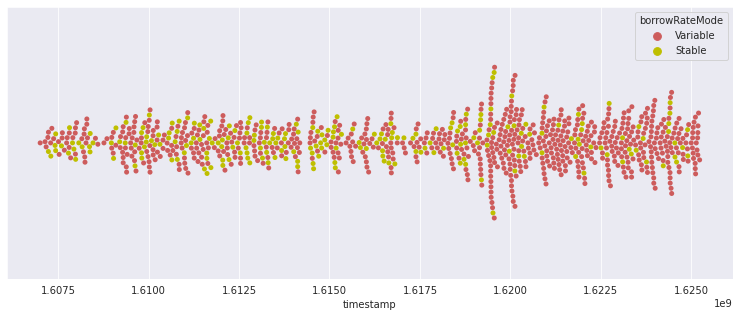

In [10]:
#get data
s = 1000
data=df.sample(s,random_state=0)

#create figure
plt.figure(figsize=(13,5))
sns.swarmplot(x=data['timestamp'],y=[""]*len(data),hue=data['borrowRateMode'],palette=['indianred','y'])
plt.show()

### What currencies are most popular for loans?

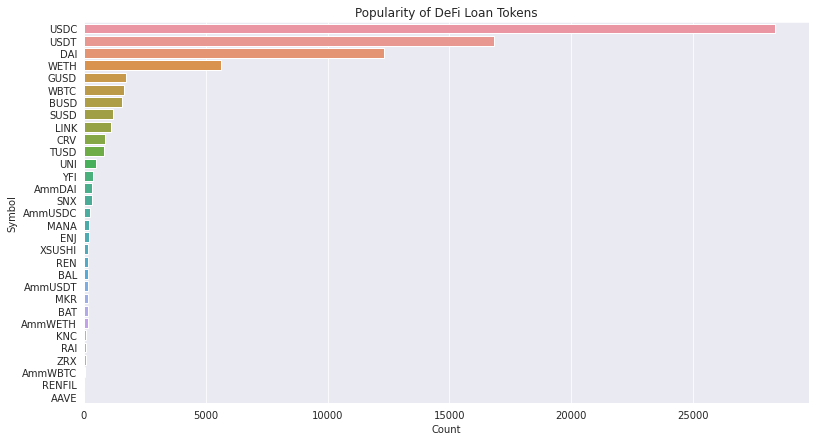

In [11]:
index=df['symbol'].value_counts().index
values=df['symbol'].value_counts().values
plt.figure(figsize=(13,7))
ax=sns.barplot(y=index,x=values)
#ax.set_xscale('log')
plt.title('Popularity of DeFi Loan Tokens')
plt.xlabel('Count')
plt.ylabel('Symbol')
plt.show()

In [12]:
all_syms = list(df['symbol'].value_counts().index)
top_syms = list(df['symbol'].value_counts()[:10].index)
df_top = df[df['symbol'].isin(top_syms)]
df_top.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71230 entries, 0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2 to 0xfffb135dcc3598530a86b484f467980798ad5af7d1cc6334d05d68d08fc2af8a:2
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   borrowRate       71230 non-null  float64       
 1   borrowRateMode   71230 non-null  object        
 2   timestamp        71230 non-null  int64         
 3   symbol           71230 non-null  object        
 4   datetime         71230 non-null  datetime64[ns]
 5   priceETH         65624 non-null  float64       
 6   priceUSD         65624 non-null  float64       
 7   amountETH        71230 non-null  float64       
 8   amountUSD        65624 non-null  float64       
 9   symbolCondensed  71230 non-null  object        
 10  log10amountETH   71230 non-null  float64       
 11  log10amountUSD   65624 non-null  float64       
 12  log10priceETH    65

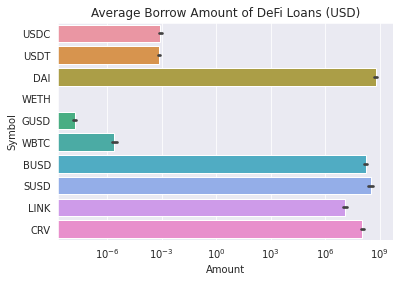

In [13]:
#make plot
ax=sns.barplot(data=df_top,y='symbol',x='amountUSD',order=top_syms)
ax.set_xscale('log')
plt.title('Average Borrow Amount of DeFi Loans (USD)')
plt.ylabel('Symbol')
plt.xlabel('Amount')
plt.show()

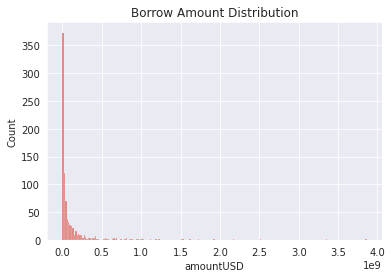

In [14]:
sns.histplot(df[df['symbol']=='CRV']['amountUSD'])
plt.title('Borrow Amount Distribution')
plt.show()

In [15]:
df[df['symbol']=='DAI'].describe()

,borrowRate,timestamp,priceETH,priceUSD,amountETH,amountUSD,log10amountETH,log10amountUSD,log10priceETH,log10priceUSD
count,12330.000000,1.233000e+04,12330.000000,12330.000000,1.233000e+04,1.233000e+04,12330.000000,12330.000000,12330.000000,12330.000000
mean,11.370435,1.616821e+09,0.000602,1.000390,2.280290e+05,6.107996e+08,3.994476,7.263313,-3.268672,0.000165
std,8.709878,5.064526e+06,0.000330,0.004337,2.244123e+06,7.159889e+09,1.071345,1.124867,0.192906,0.001883
min,0.075189,1.606841e+09,0.000232,0.956098,1.000000e-05,5.850849e-03,-5.000000,-2.232781,-3.634999,-0.019498
25%,3.954538,1.612252e+09,0.000393,0.997508,2.286946e+03,4.080999e+06,3.359256,6.610766,-3.405663,-0.001084
50%,8.987059,1.617682e+09,0.000510,1.000250,1.000000e+04,1.700593e+07,4.000000,7.230600,-3.292021,0.000109
75%,15.355613,1.621193e+09,0.000703,1.003159,4.700000e+04,8.836008e+07,4.672098,7.946256,-3.152890,0.001370
max,79.000000,1.625245e+09,0.002140,1.026260,8.200000e+07,3.134946e+11,7.913814,11.496230,-2.669513,0.011257


### How does interest rate vary between currencies?

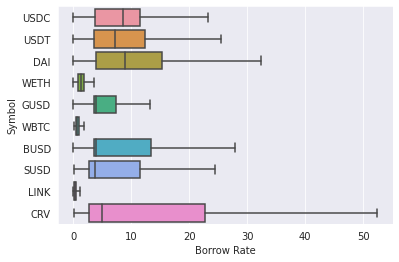

In [16]:
#make plot
sns.boxplot(data=df_top,y='symbol',x='borrowRate',showfliers=False,order=top_syms)
plt.ylabel('Symbol')
plt.xlabel('Borrow Rate')
plt.show()

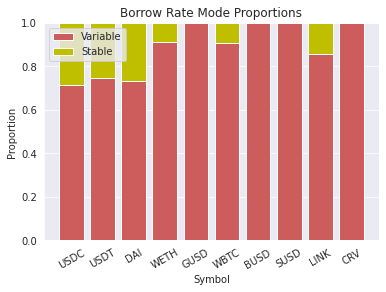

In [17]:
#get data
prop_var =[]
prop_stable=[]
for sym in top_syms:
    group = df[df['symbol']==sym]
    prop=(group['borrowRateMode']=='Variable').sum()/len(group)
    prop_var.append(prop)
    prop_stable.append(1-prop)

#make plot
plt.bar(top_syms, prop_var,color='indianred')
plt.bar(top_syms, prop_stable,bottom=prop_var,color='y')
plt.legend(['Variable','Stable'])
plt.title('Borrow Rate Mode Proportions')
plt.xlabel('Symbol')
plt.ylabel('Proportion')
plt.xticks(rotation=30)
plt.show()

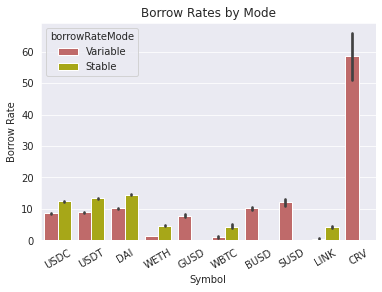

In [18]:
#make plot
sns.barplot(data=df_top,x='symbol',y='borrowRate',hue='borrowRateMode',order=top_syms,palette=['indianred','y'])
plt.xlabel('Symbol')
plt.ylabel('Borrow Rate')
plt.title('Borrow Rates by Mode')
plt.xticks(rotation=30)
plt.show()

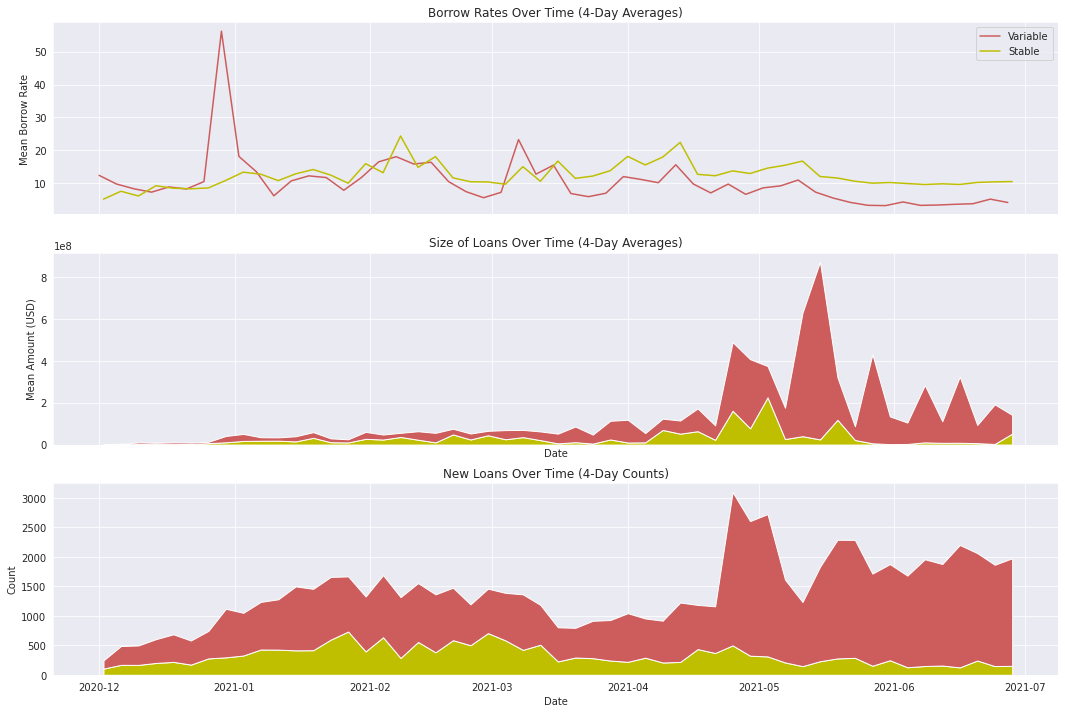

In [21]:
#set figure
fig,ax =plt.subplots(3,1,sharex=True)
fig.set_size_inches(18, 12, forward=True)

#get data
data_stable=df[df['borrowRateMode']=='Stable'].set_index('datetime').resample('4D')['borrowRate'].mean()[:-1]
data_variable=df[df['borrowRateMode']=='Variable'].set_index('datetime').resample('4D')['borrowRate'].mean()[:-1]

#make plot
sns.lineplot(x=data_variable.index,y=data_variable.values,ax=ax[0],color='indianred')
sns.lineplot(x=data_stable.index,y=data_stable.values,ax=ax[0],color='y')
ax[0].set_title('Borrow Rates Over Time (4-Day Averages)')
ax[0].legend(['Variable','Stable'])
ax[0].set_ylabel('Mean Borrow Rate')

#get data
data_stable=df[df['borrowRateMode']=='Stable'].set_index('datetime').resample('4D')['amountUSD'].mean()[:-1]
data_variable=df[df['borrowRateMode']=='Variable'].set_index('datetime').resample('4D')['amountUSD'].mean()[:-1]

#make plot
ax[1].stackplot(data_stable.index,data_stable.values,data_variable.values,colors=['y','indianred'])
ax[1].set_title('Size of Loans Over Time (4-Day Averages)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Mean Amount (USD)')

#get data
data_stable=df[df['borrowRateMode']=='Stable'].set_index('datetime').resample('4D').size()[:-1]
data_variable=df[df['borrowRateMode']=='Variable'].set_index('datetime').resample('4D').size()[:-1]

#make plot
ax[2].stackplot(data_stable.index,data_stable.values,data_variable.values,colors=['y','indianred'])
ax[2].set_title('New Loans Over Time (4-Day Counts)')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Count')

plt.show()

### How do these variables correlate with eachother?

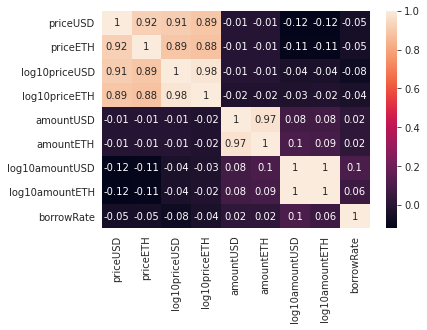

In [22]:
sns.heatmap(df[['priceUSD','priceETH','log10priceUSD','log10priceETH','amountUSD','amountETH','log10amountUSD','log10amountETH',
                'borrowRate']].corr().round(2),annot=True)
plt.show()

/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/etc/

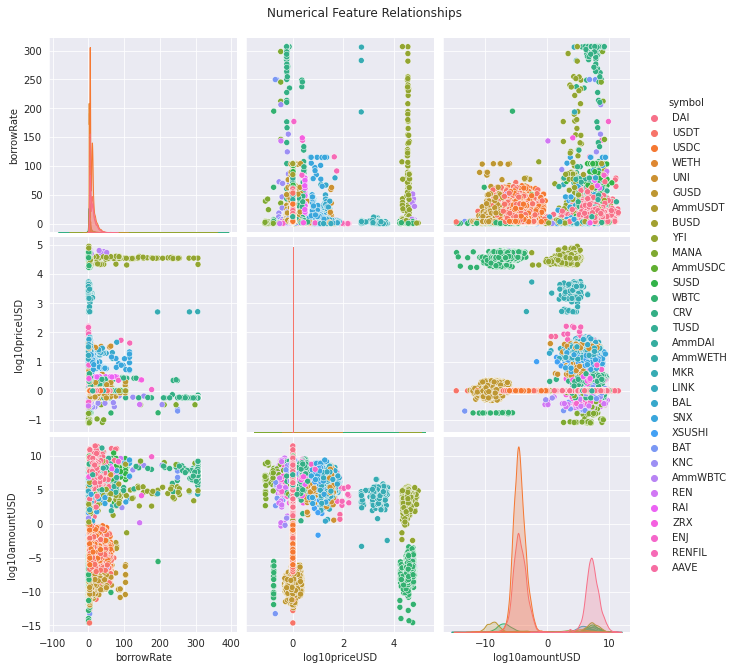

In [26]:
g=sns.pairplot(data=df,vars=['borrowRate','log10priceUSD','log10amountUSD'],hue='symbol',height=3,aspect=1)
g.fig.suptitle("Numerical Feature Relationships", y=1.03)
plt.show()

## Machine Learning

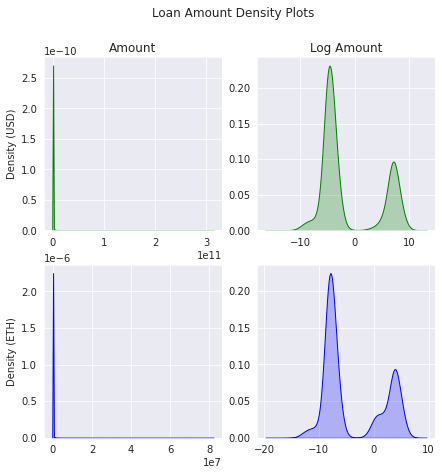

In [62]:
#set up figure 
fig,ax =plt.subplots(2,2)
fig.set_size_inches(7, 7, forward=True)
fig.suptitle('Loan Amount Density Plots')

#set up log10amount USD chart
sns.kdeplot(df['amountUSD'],ax=ax[0][0],color='green',fill=True)
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('Density (USD)')
ax[0][0].set_title('Amount')

#set up log10amount ETH chart
sns.kdeplot(df['amountETH'],ax=ax[1][0],color='blue',fill=True)
ax[1][0].set_xlabel('')
ax[1][0].set_ylabel('Density (ETH)')

#set up amount USD chart
sns.kdeplot(df['log10amountUSD'],ax=ax[0][1],color='green',fill=True)
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('')
ax[0][1].set_title('Log Amount')

#set up amount ETH chart
sns.kdeplot(df['log10amountETH'],ax=ax[1][1],color='blue',fill=True)
ax[1][1].set_xlabel('')
ax[1][1].set_ylabel('')
plt.show()

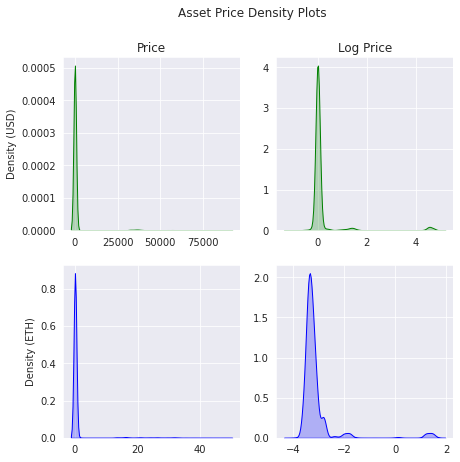

In [65]:
#set up figure 
fig,ax =plt.subplots(2,2)
fig.set_size_inches(7, 7, forward=True)
fig.suptitle('Asset Price Density Plots')

#set up log10amount USD chart
sns.kdeplot(df['priceUSD'],ax=ax[0][0],color='green',fill=True)
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('Density (USD)')
ax[0][0].set_title('Price')

#set up log10amount ETH chart
sns.kdeplot(df['priceETH'],ax=ax[1][0],color='blue',fill=True)
ax[1][0].set_xlabel('')
ax[1][0].set_ylabel('Density (ETH)')

#set up amount USD chart
sns.kdeplot(df['log10priceUSD'],ax=ax[0][1],color='green',fill=True)
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('')
ax[0][1].set_title('Log Price')

#set up amount ETH chart
sns.kdeplot(df['log10priceETH'],ax=ax[1][1],color='blue',fill=True)
ax[1][1].set_xlabel('')
ax[1][1].set_ylabel('')
plt.show()

### Clustering

In [96]:
numeric=['priceUSD','priceETH','log10amountUSD','log10amountETH','borrowRate']
df_cl = df.dropna().copy()
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69939 entries, 0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2 to 0xffff326c674a3e4dea890793aae76e4f63cdf2591a7bf8ebe0ddbcdcb986a64c:2
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   borrowRate       69939 non-null  float64       
 1   borrowRateMode   69939 non-null  object        
 2   timestamp        69939 non-null  int64         
 3   symbol           69939 non-null  object        
 4   datetime         69939 non-null  datetime64[ns]
 5   priceETH         69939 non-null  float64       
 6   priceUSD         69939 non-null  float64       
 7   amountETH        69939 non-null  float64       
 8   amountUSD        69939 non-null  float64       
 9   symbolCondensed  69939 non-null  object        
 10  log10amountETH   69939 non-null  float64       
 11  log10amountUSD   69939 non-null  float64       
 12  log10priceETH    69

In [97]:
scaler = StandardScaler()
df_cl[numeric]= scaler.fit_transform(df_cl[numeric])
df_cl[numeric].describe()

,priceUSD,priceETH,log10amountUSD,log10amountETH,borrowRate
count,6.993900e+04,6.993900e+04,6.993900e+04,6.993900e+04,6.993900e+04
mean,-1.183578e-17,2.011574e-17,-3.413580e-17,-9.407663e-17,-5.526748e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.687838e-01,-1.657169e-01,-2.425800e+00,-2.434633e+00,-6.051927e-01
25%,-1.686525e-01,-1.656406e-01,-6.799774e-01,-6.810597e-01,-3.948993e-01
50%,-1.686523e-01,-1.656136e-01,-5.085613e-01,-5.100973e-01,-2.162653e-01
75%,-1.686519e-01,-1.655595e-01,1.298466e+00,1.309209e+00,9.842031e-02
max,1.262730e+01,1.187528e+01,2.293102e+00,2.234492e+00,1.718013e+01


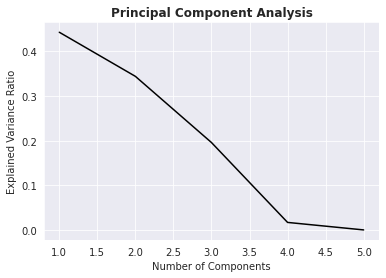

In [98]:
#fit PCA for all numerical columns
pca = PCA()
pca.fit(df_cl[numeric])

#plot explained variance ratio by number of components
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Principal Component Analysis',fontweight='bold')
sns.lineplot(x=np.arange(len(numeric))+1, y=pca.explained_variance_ratio_, color='black')
plt.show()

In [107]:
#add pcs to dataframe
pcs = pca.fit_transform(df_cl[numeric])
pc_labels=[]
for pc in range(1,len(pcs.transpose())+1):
    pc_labels.append('PC'+str(pc))
    df_cl['PC'+str(pc)]=pcs.transpose()[pc-1]
    
df_cl[pc_labels].head()

,PC1,PC2,PC3,PC4,PC5
id,,,,,
0x000204ea4ee37c90d078b2539e30f060b45d5b2de33afb187e3468b59d6e6fb0:2,-1.925968,1.285991,-0.548371,-0.006642,-0.034060
0x000334ec383beb111301d7fb6cef1598bcf8cc32892531ef48a8cd52a19674b5:2,0.024689,-0.302094,-0.441130,0.004322,-0.015477
0x000344899fcef352340bea6c5752e6ac04293e6261fe5bcddadd0600db897439:2,0.499917,-0.710349,0.001679,0.005642,-0.019359
0x0004993ae67e98551c81a412bba4e1687d4db3451d7ee181e108f9e7e3fa0dfa:2,0.283936,-0.653108,2.306819,-0.002115,-0.002778
0x00050939611f937beeda8250a0159c9bbab0927257074090897161b61bc1de80:2,0.426707,-0.641171,-0.190018,0.005578,-0.034219


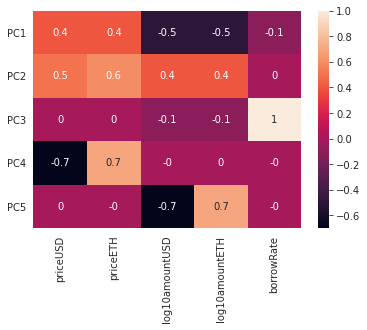

In [108]:
#show PC components
sns.heatmap(pca.components_.round(1),yticklabels=[ "PC"+str(x) for x in range(1,pca.n_components_+1)],
            xticklabels=numeric,annot=True)
plt.yticks(rotation=0) 

plt.show()

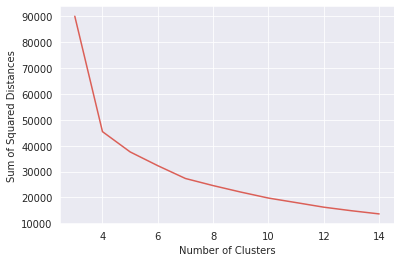

In [118]:
#get data for sum of squared distances for number of clusters
distances=[]
for k in range(3,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans = kmeans.fit(df_cl[pc_labels])
    distances.append(kmeans.inertia_)

#create plot
plt.plot(range(3,15),distances)
plt.title('')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

plt.show()

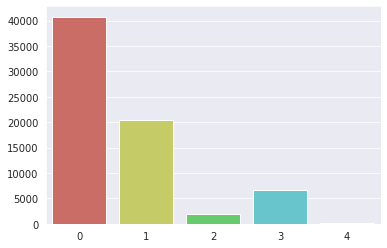

In [124]:
#compute clusters
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters,random_state=0)
kmeans = kmeans.fit(df_cl[pc_labels])
df_cl['cluster']=kmeans.labels_

#make plot showing counts of clusters
sns.barplot(x=df_cl['cluster'].value_counts().index,y=df_cl['cluster'].value_counts().values,
            palette=sns.color_palette("hls")[:n_clusters])

plt.title('Cluster Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

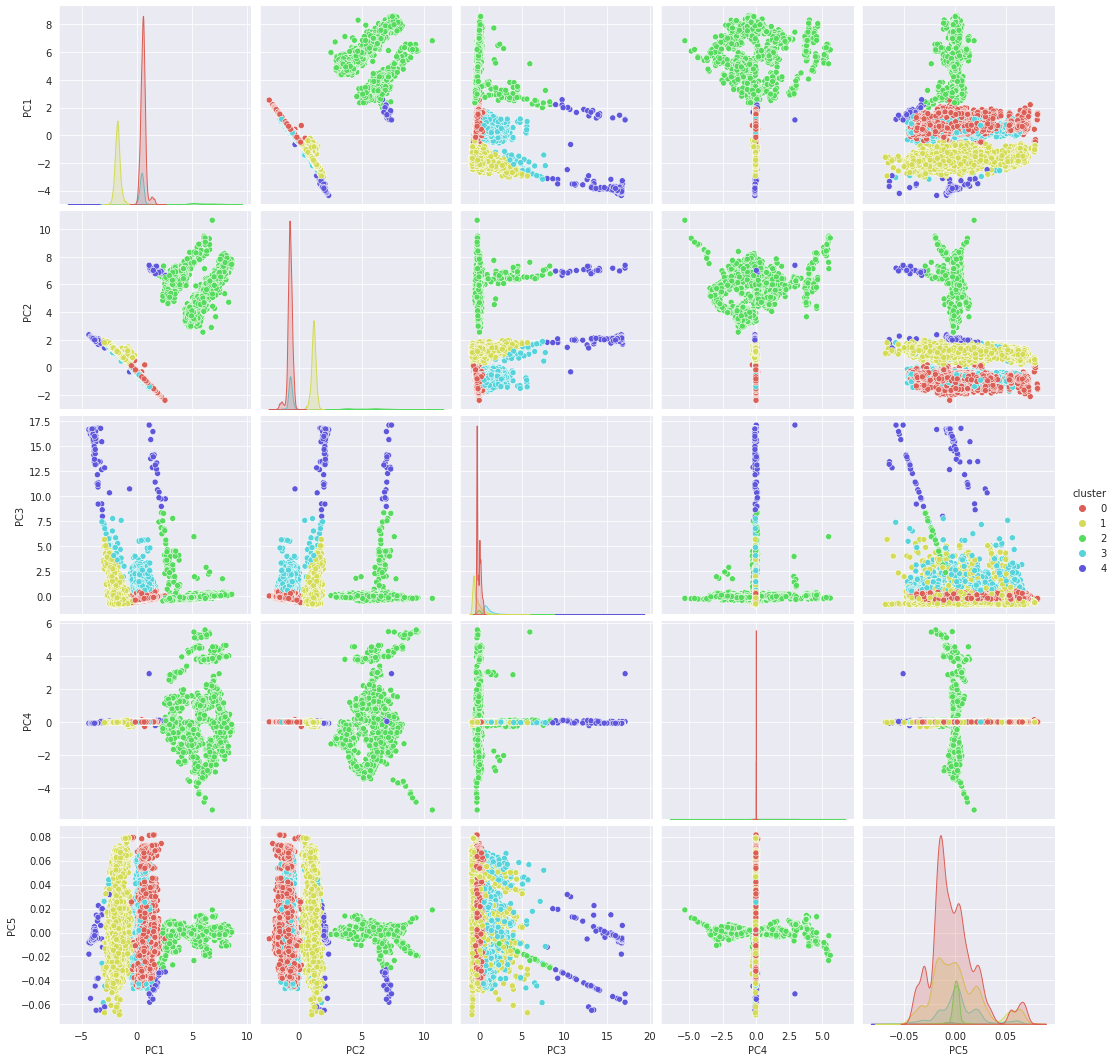

In [125]:
g=sns.pairplot(data=df_cl,vars=pc_labels,hue='cluster',height=3,aspect=1,palette = sns.color_palette("hls")[:n_clusters])
plt.show()

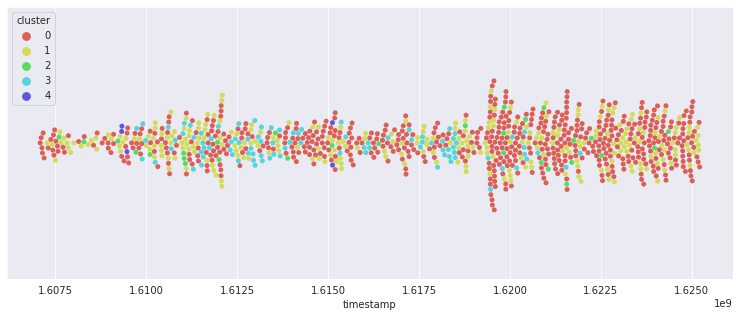

In [126]:
#get data
s = 1000
data=df_cl.sample(s,random_state=0)

#create figure
plt.figure(figsize=(13,5))
sns.swarmplot(x=data['timestamp'],y=[""]*len(data),hue=data['cluster'],palette=sns.color_palette("hls")[:n_clusters])
plt.show()